In [1]:
# add parent dir to syspath
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

In [2]:
from cyclegan.cyclegan import cyclegan
from dataset import load_realdata
from imageGenerators.imgGen_simple import synth_generator
from imageGenerators.imgGen_augmented import synth_generator as synth_generator_new

import tensorflow as tf
import cv2
from pathlib import Path
from matplotlib import pyplot as plt
from os import listdir, mkdir
import os
import numpy as np
import time
import pickle
import random

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
# assert model is running on gpu
from tensorflow.python.client import device_lib
devlist = str(device_lib.list_local_devices())
assert "GPU:0" in devlist

In [4]:
# possible datasets which can be used for domains A and B
datasets = [
    # synth images from random digits
    "synthetic_random",
    
    # synth images with labels: (0,0,0,0,0), (1,1,1,1,1), ... (19,19,19,19,19)
    "synthetic_allDigits",
    
    # real images
    "real_easy",
    "real_diff_train",
    "real_diff_test",
    
    "real_diff_subset", # use subset of real diff train
    "real_easy_train", # use subset of real easy images for training    
    
    # generate images using another model, already trained
    "gen"
]

In [5]:
## parameters
# domains to translate between
domain_A = "synthetic_random"
domain_B = "real_easy"
assert domain_A in datasets and domain_B in datasets, "unknown dataset"

# when using a subset of real images, how many images to use
subset_size=500

# dimensions, shape
IMAGE_DIMENSIONS = (512, 128)
N_CHANNELS = 1
#              height,              width,               channels
IMAGE_SHAPE = (IMAGE_DIMENSIONS[1], IMAGE_DIMENSIONS[0], N_CHANNELS)

# where to save model (in folder cyclegan/saved_models)
model_name = Path("test_model")

# when taking the output of another pretrained cyclegan model as input, which model to use
generator_model = Path("synth2easy")
generator_epoch = 17

# whether to load model and continue training
continue_training=False
continue_epoch = 5 if continue_training else None 

## Training parameters
# number of digits in each image
N_DIGITS = 5

BATCH_SIZE = 1
BUFFER_SIZE = 1000
N_IMAGES = 5#00
EPOCHS = 30

lr=0.0002
adversial_lossfunction = "bce" # either mse or bce
_lambda = 10 # weight of cycleloss
poolsize=0
smallModel = True # use smaller version of cyclegan


In [6]:
## functions to display image/s

# show single image
def showImage(image, normalized=False):
    if normalized:
        vmin=-1; vmax=1
    else:
        vmin=0; vmax=255
    if len(image.shape) == 3 and image.shape[2] == 1:
        image = image[:,:,0]
    #image = image.astype(int)
    plt.imshow(image, cmap="gray", vmin=vmin, vmax=vmax)
    plt.show()
    
# show multiple images, 
# show maximum of n images,
# print labels when given
def showImages(images, n, labels=None, normalized=False):
    for i in range(min(n, len(images))):
        if not labels is None:
            print(labels[i])
        image = images[i]
        showImage(image, normalized)
        
# normalization functions
def normalize(images):
    images = tf.cast(images, dtype=tf.float32)
    images = (images / 127.5) - 1
    return images
def denormalize(images):    
    images = (images + 1) * 127.5
    images = tf.cast(images, dtype=tf.uint8)
    return images

In [7]:
# given array of labels <digits>,
# return array of generated synthetic images
def generate_synthetic(digits, show_generated=0):
    synthGenerator = synth_generator_new()    
    synth = synthGenerator.makeImages(digits, resizeTo=IMAGE_DIMENSIONS, color=True, rotate=True)
    return synth

-----------------
synthetic_allDigits
[0, 0, 0, 0, 0]


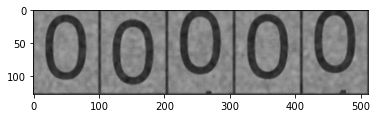

[1, 1, 1, 1, 1]


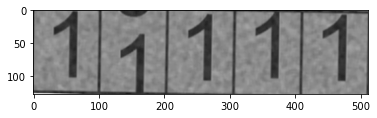

[2, 2, 2, 2, 2]


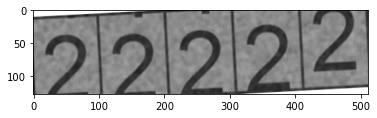

[3, 3, 3, 3, 3]


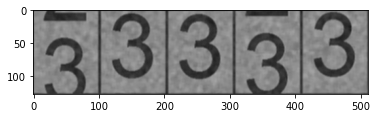

[4, 4, 4, 4, 4]


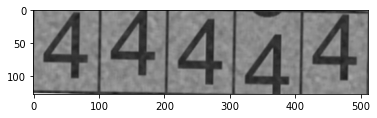

-----------------
synthetic_random
[ 2 12  6  4  6]


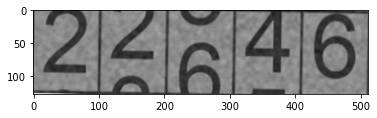

[7 5 0 0 2]


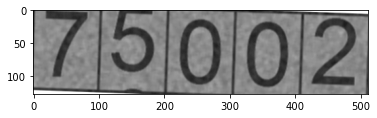

[13  4  5 18  1]


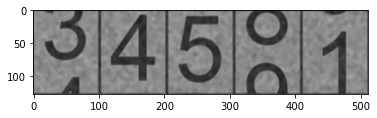

[9 1 0 6 1]


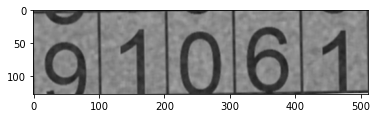

[11  7 17  3 14]


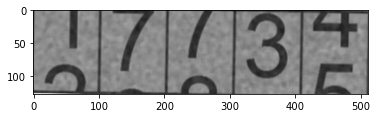

-----------------
real_easy_train
[ 6  3  2  0 14]


C:\Users\andre\Desktop\m\schriftlich\master\code\dataset\load_realdata.py:62: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(txt_path, sep=seperators ,header=None)


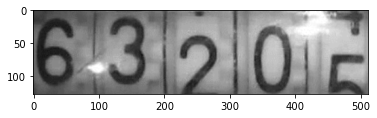

[2 0 1 7 0]


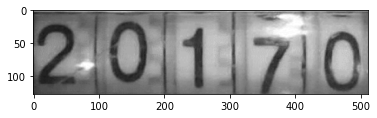

[1 8 4 2 8]


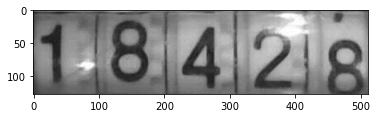

[ 5  7  5 18  9]


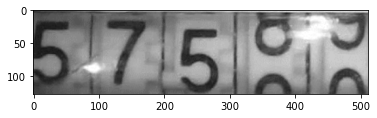

[ 6  3  6  8 16]


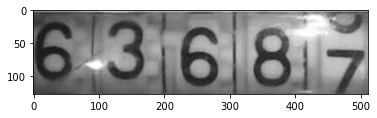

In [8]:
###
# given a string denoting a dataset, returns:
#   dataset <dataset_images>, list <labels>: input for training cyclegan
#   dataset <images_test>, list <labels_test>: input for generating samples
###
def loadData(datasetString, showImages=5):
    images_test=None; labels_test=None
    
    # return synthetic images with random digits (+ return synthetic images with every digit for sampling)
    if datasetString == "synthetic_random":
        labels = np.random.randint(0,20,size=(N_IMAGES, N_DIGITS))
        images = generate_synthetic(labels, show_generated=0)
        images_test, labels_test,_,_ = loadData("synthetic_allDigits", showImages=5)
    # return 20 synthetic images, one for each digit
    elif datasetString == "synthetic_allDigits":
        labels = [
            [digit for _ in range(N_DIGITS)]
            for digit in range(20)
        ]
        images = generate_synthetic(labels, show_generated=0)
    # return easy images from wmr
    elif datasetString == "real_easy":
        images, labels = load_realdata.load_wmr_easy(N_IMAGES, resizeTo=IMAGE_DIMENSIONS, channels=1)
        images_test, labels_test = load_realdata.load_wmr_easy(20, resizeTo=IMAGE_DIMENSIONS, channels=1)
    # return difficult images for training from wmr
    elif datasetString == "real_diff_train":
        images, labels = load_realdata.load_wmr_diff_train(N_IMAGES, resizeTo=IMAGE_DIMENSIONS, channels=1)
        #images_test, labels_test,_,_ = loadData("real_diff_test", showImages=5)
    # return difficult images for testing from wmr
    elif datasetString == "real_diff_test":
        images, labels = load_realdata.load_wmr_diff_test(N_IMAGES, resizeTo=IMAGE_DIMENSIONS, channels=1)
    # return subset of real difficult images from wmr 
    elif datasetString == "real_diff_subset":
        images, labels = load_realdata.load_diff_split(N_IMAGES, resizeTo=IMAGE_DIMENSIONS, channels=1, n=subset_size)
        #images_test, labels_test,_,_ = loadData("real_diff_test", showImages=5)
        
    # return subset of easy images for training
    elif datasetString == "real_easy_train":
        data_train, data_test = load_realdata.load_wmr_easy_split(N_IMAGES, resizeTo=IMAGE_DIMENSIONS, channels=1)
        images, labels = data_train
        images_test, labels_test = data_test 
        images_test = images_test[0:20]
        labels_test = labels_test[0:20]
    # return subset of easy images for testing
    #elif datasetString == "real_easy_test":
        
    # load another pretrained cyclegan model, translate synthetic random images and return output
    elif datasetString == "gen":
        # load pretrained model, generate synthethic images, translate images
        images_input, labels, test_input, test_labels = loadData("synthethic_random")
        model_gen = cyclegan(image_shape=IMAGE_SHAPE,
                   n_images=N_IMAGES,
                   batchsize=BATCH_SIZE,
                   adversial_loss=adversial_lossfunction,
                   lr=lr,
                   _lambda=_lambda,
                   poolsize=poolsize,
                   checkpoint_path=generator_model,
                   smallModel=smallModel,
                   load_checkpoint_after_epoch=generator_epoch
                  )
        images = model_gen.gen_AtoB.predict(images_input)
        images = denormalize(images)
        images_test = model_gen.gen_AtoB.predict(test_input)
        images_test = denormalize(images_test)
        
    else:
        raise "unknown dataset"
        
    # preview images
    print("-----------------")
    print(datasetString)
    for i in range(showImages):
        print(labels[i])
        showImage(images[i])
    
    # make dataset and return
    dataset_images = tf.data.Dataset.from_tensor_slices(images) \
        .map(normalize, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(BATCH_SIZE)
    if not images_test is None and not isinstance(images_test, tf.data.Dataset):        
        images_test = tf.data.Dataset.from_tensor_slices(images_test) \
        .map(normalize, num_parallel_calls=AUTOTUNE) \
        .cache() \
        .batch(BATCH_SIZE)
        
    return dataset_images, labels, images_test, labels_test



train_A, labels_A, test_A_images, test_A_labels  = loadData(domain_A)
train_B, labels_B, _,_ = loadData(domain_B)

In [9]:
# load model
if continue_training:
    # load a pretrained model
    cgModel = cyclegan(image_shape=IMAGE_SHAPE,
                   n_images=N_IMAGES,
                   batchsize=BATCH_SIZE,
                   adversial_loss=adversial_lossfunction,
                   lr=lr,
                   _lambda=_lambda,
                   poolsize=poolsize,
                   checkpoint_path=model_name,
                   smallModel=smallModel,
                   load_checkpoint_after_epoch=continue_epoch
                  )
    # create a new subdir for training
    model_name = model_name/ ( "next_after_%d" % (continue_epoch) )
    cgModel.set_checkpointDir(model_name)
else:
    cgModel = cyclegan(image_shape=IMAGE_SHAPE,
                   n_images=N_IMAGES,
                   batchsize=BATCH_SIZE,
                   adversial_loss=adversial_lossfunction,
                   lr=lr,
                   _lambda=_lambda,
                   poolsize=poolsize,
                   checkpoint_path=model_name,
                   smallModel=smallModel
                  )
   

created new Model


epoch 1:
5/5 [==============================] - 25s 5s/step

epoch 1 took: 25.646333 seconds
saved to: C:\Users\andre\Desktop\m\schriftlich\master\code\cyclegan\saved_models\test5\epoch-1
epoch 2:
5/5 [==============================] - 2s 500ms/step

epoch 2 took: 2.832514 seconds
saved to: C:\Users\andre\Desktop\m\schriftlich\master\code\cyclegan\saved_models\test5\epoch-2
epoch 3:
5/5 [==============================] - 2s 499ms/step

epoch 3 took: 2.828492 seconds
saved to: C:\Users\andre\Desktop\m\schriftlich\master\code\cyclegan\saved_models\test5\epoch-3
epoch 4:
5/5 [==============================] - 2s 499ms/step

epoch 4 took: 2.828889 seconds
saved to: C:\Users\andre\Desktop\m\schriftlich\master\code\cyclegan\saved_models\test5\epoch-4
epoch 5:
5/5 [==============================] - 3s 501ms/step

epoch 5 took: 2.832042 seconds
saved to: C:\Users\andre\Desktop\m\schriftlich\master\code\cyclegan\saved_models\test5\epoch-5
epoch 6:
5/5 [==============================] - 3s 500ms

SystemError: <built-in method write of _io.BufferedWriter object at 0x000002812D9DBE08> returned a result with an error set

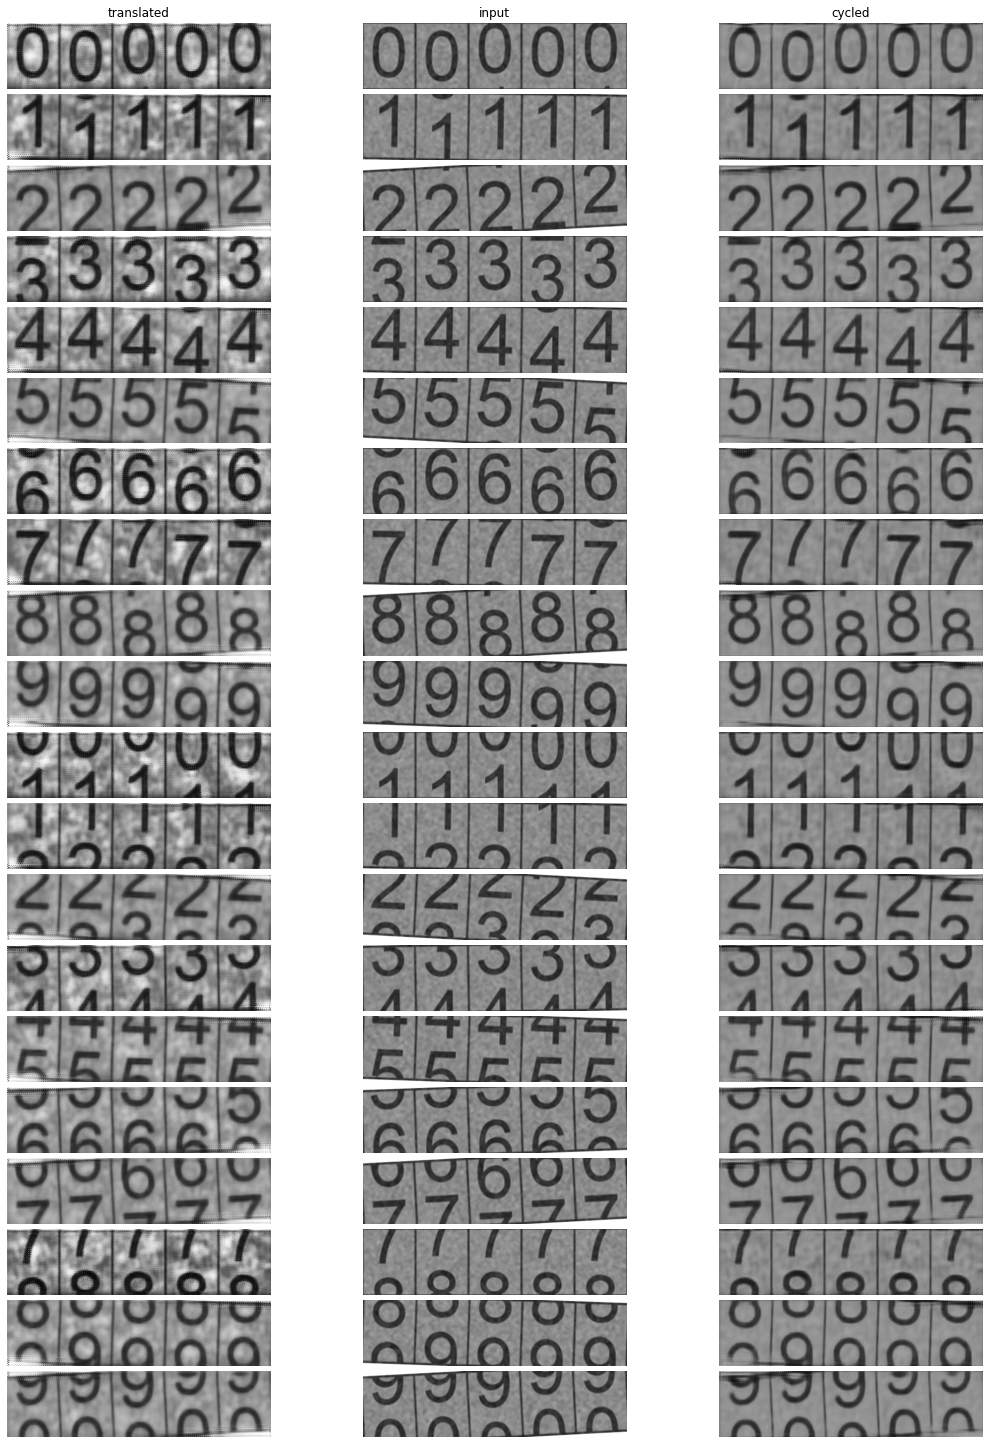

In [10]:
# train model
cgModel.train(train_A, train_B, test_A_images, epochs=EPOCHS, epochs_before_save=1, printStepTime=False)